In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, TimeDistributed, Concatenate
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Using TensorFlow backend.


In [2]:
def encode_categoricals(df, col_names):
    for col in col_names:
        onehots = to_categorical(df[col].values)
        onehot_df = pd.DataFrame(onehots, columns=[col + "_" + str(i) for i in range(onehots.shape[1])])
        df = pd.concat([df.drop(col, axis=1), onehot_df], axis=1)
    return df

In [107]:
def convert_to_padded_seqs(df, keep_seq=False):
    seqs = []
    subseq = []
    for ix, row in df.iterrows():
        if row['seq'] == 1 and subseq != []:
            seqs.append(subseq)
            subseq = []
        if not keep_seq:
            row = row.drop('seq')
        subseq.append(list(row.values))
    sequences = pad_sequences(seqs, padding='post', dtype='float64')
    return sequences

In [4]:
def fix_angle(angle):
    if angle > 180.0:
        return 360.0 - angle 
    elif angle == 0:
        return 0.0
    else:
        return -angle

In [103]:
# Convert to a DataFrame and render.
import pandas as pd
df = pd.read_csv('app/data-capture-2-10-904.csv')
df.drop(['NOTES:', 'Unnamed: 11', 'Unnamed: 12', 'alignment'], axis=1, inplace=True)
df = df.rename(columns={
      "xxz": "seq",
      "x (out of 300)": "x",
      "y (out of 400)": "y",
      "# of characters": "chars",
      "font size": "font_size",
      "# of words": 'words',
      "lines of text": 'lines',
      "caps or lowercase": 'caps'
    })
df['weight'] = df['font weight'].apply(lambda x: x.split(' ')[-1])
df['condensed'] = df['font weight'].str.contains('condensed').astype(int)
df.drop('font weight', axis=1, inplace=True)
df = df.replace(
    {'weight':{
        'light': 0,
        'regular': 1,
        'medium': 2,
        'bold': 3
     },
     'caps': {
         'C': 1,
         'L': 0
     }
})
df = encode_categoricals(df, ['weight'])
continuous_vars = ['seq','x', 'y', 'rotation', 'font_size', 'chars', 'lines']
df.rotation = df.rotation.apply(fix_angle)
df = df[continuous_vars]

In [104]:
df

,seq,x,y,rotation,font_size,chars,lines
0,1,11,26,-8.00,16.25,15,1
1,2,142,11,-8.00,11.64,9,1
2,3,17,86,-23.69,49.74,4,1
3,4,12,135,-12.58,73.67,9,1
4,5,15,194,-2.11,16.25,11,1
5,6,141,190,-2.11,16.25,12,1
6,7,53,210,34.66,39.42,6,1
7,8,142,280,34.66,27.46,6,1
8,9,184,318,34.66,18.56,6,1
9,10,228,353,34.66,11.46,6,1


In [105]:
def scale_df(df):
    new_df = pd.DataFrame()
    new_df['seq'] = df.seq
    new_df['x'] = (df.x - 150.0) / 150.0
    new_df['y'] = (df.y - 200.0) / 200.0
    new_df['rotation'] = df.rotation / 180
    font_size_max = df.font_size.max()
    chars_max = df.chars.max()
    lines_max = df.lines.max()
    new_df['font_size'] = df.font_size / font_size_max
    new_df['chars'] = df.chars / chars_max
    new_df['lines'] = df.lines / lines_max
    def unscale(df):
        unscaled = pd.DataFrame()
        unscaled['x'] = (df.x * 150.0) + 150.0
        unscaled['y'] = (df.y * 200.0) + 200.0
        unscaled['rotation'] = df.rotation * 180
        unscaled['font_size'] = df.font_size * font_size_max
        unscaled['chars'] = df.chars * chars_max
        unscaled['lines'] = df.lines * lines_max
        return unscaled
    return new_df, unscale

In [86]:
def scale_df_minmax(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.iloc[:,1:])
    return pd.concat([df.iloc[:,0], pd.DataFrame(scaled)], axis=1), scaler

In [108]:
scaled, unscale = scale_df(df)
keras_ready = convert_to_padded_seqs(scaled, keep_seq=True)

In [122]:
inp = keras.Input((None, 1))
rnn = LSTM(16, activation='tanh', dropout=0.5, return_sequences=True)(inp)
dense1 = TimeDistributed(Dense(6, activation='linear'))(rnn)
# dense2 = TimeDistributed(Dense(3, activation='relu'))(rnn)
# output = Concatenate()([dense1, dense2])
model = keras.models.Model(input=inp, output=dense1)
model.compile(loss='mean_squared_error',
              optimizer='adam')

X = keras_ready[:,:-1,[0]]
Y = keras_ready[:,1:,1:]

h = model.fit(x=X, y=Y, batch_size=1, epochs=12)

/Users/brian/.virtualenvs/typeforce/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  


Epoch 1/12
16/16 [==============================] - 2s 106ms/step - loss: 0.0961
Epoch 2/12
16/16 [==============================] - 0s 13ms/step - loss: 0.0990
Epoch 3/12
16/16 [==============================] - 0s 14ms/step - loss: 0.0824
Epoch 4/12
16/16 [==============================] - 0s 14ms/step - loss: 0.0783
Epoch 5/12
16/16 [==============================] - 0s 14ms/step - loss: 0.0671
Epoch 6/12
16/16 [==============================] - 0s 13ms/step - loss: 0.0674
Epoch 7/12
16/16 [==============================] - 0s 14ms/step - loss: 0.0633
Epoch 8/12
16/16 [==============================] - 0s 16ms/step - loss: 0.0630
Epoch 9/12
16/16 [==============================] - 0s 16ms/step - loss: 0.0606
Epoch 10/12
16/16 [==============================] - 0s 17ms/step - loss: 0.0610
Epoch 11/12
16/16 [==============================] - 0s 18ms/step - loss: 0.0622
Epoch 12/12
16/16 [==============================] - 0s 16ms/step - loss: 0.0588


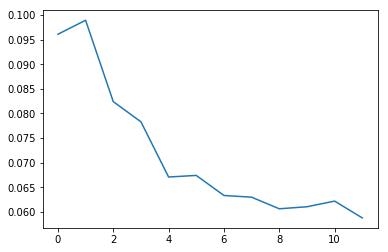

In [123]:
pd.Series(h.history['loss']).plot()

In [138]:
def get_seq_from_model():
    seq = []
    for i in range(0,30):
        prediction = model.predict(np.reshape(np.array(float(i)),(1,1,1)))
        seq.append(prediction)
    return np.squeeze(np.concatenate(seq))

results = get_seq_from_model()

In [139]:
results = unscale(pd.DataFrame(results, columns=df.columns[1:]))

In [140]:
results

,x,y,rotation,font_size,chars,lines
0,144.153198,206.271973,-2.006283,12.414235,8.037454,0.717947
1,137.822006,201.001495,3.718224,19.256708,12.384882,0.618998
2,132.190765,200.625122,7.747037,23.063263,16.066551,0.539207
3,127.666473,204.060120,9.858997,23.698215,18.574463,0.495258
4,124.239494,209.609848,10.310140,22.098755,19.897842,0.480889
5,121.642532,216.048538,9.515779,19.125874,20.300631,0.484429
6,119.556656,222.737793,7.869185,15.274820,20.089808,0.497161
7,117.816742,229.524384,5.629521,10.702517,19.539267,0.511495
8,116.261185,236.353638,3.021760,5.464671,18.801531,0.525647
9,115.083862,242.320862,0.130989,-0.129969,17.538660,0.557445


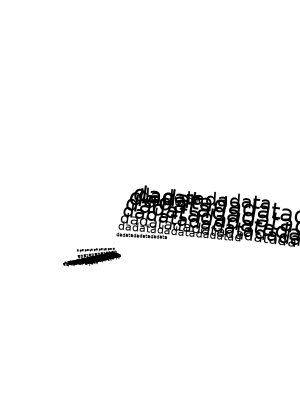

In [141]:
SVG(draw_poster(results))

In [82]:
np.reshape(keras_ready[None,[0],:2,:], (1,2,6))

array([[[-0.92666667, -0.87      , -0.04444444,  0.07274274,
          0.0872093 ,  0.09090909],
        [-0.05333333, -0.945     , -0.04444444,  0.05210618,
          0.05232558,  0.09090909]]])

In [308]:
inp = keras_ready[None, [0],[0], :]
out = model.predict(inp, batch_size=1)
out2 = model.predict(np.concatenate([inp, out]))[[-1]]
out3 = model.predict(np.concatenate([inp, out, out2]))[[-1]]
print(1, inp)
print(2, out)
print(3, out2)
print(4, out3)


1 [[[0.04135338 0.05026455 0.52347383 0.06220572 0.08187135 0.        ]]]
2 [[[0.12656654 0.15340796 0.21817307 0.02150103 0.07983124 0.03264903]]]
3 [[[0.13095048 0.14700052 0.2039831  0.02105428 0.09051767 0.03955364]]]
4 [[[0.13147429 0.14658271 0.20494547 0.01992092 0.09144083 0.0399652 ]]]


In [291]:
out.shape

(1, 1, 6)

In [29]:
from IPython.display import SVG
import xml.etree.ElementTree as ET
import math

def dadata(length):
    return ("dadata" * math.ceil(length/6))[:length]

def draw_poster(data):
    svg = ET.Element('svg', xmlns="http://www.w3.org/2000/svg", version="1.1",
                     height="400", width="300")
    txt_settings = {
        "text_anchor":"start",
        "font-family":"Helvetica Neue",
        
    }
    for ix, row in data.iterrows():
        text = ET.SubElement(svg,"text", 
                             x=str(row.x), y=str(row.y),
                             transform="rotate({} {} {})".format(row.rotation, row.x, row.y),
                            )
        text.set('font-size', str(row.font_size))
        text.set('font-size', str(row.font_size))

        text.text=dadata(int(row.chars))
    return ET.tostring(svg)

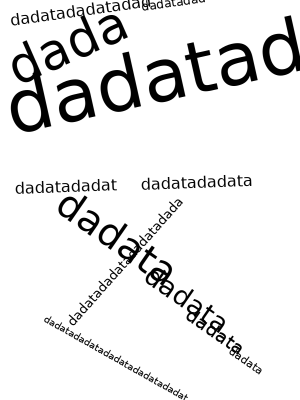

In [162]:
SVG(draw_poster(df[:12]))

In [ ]:
df. 